In [ ]:
from hcat.unet import Unet_Constructor as GUnet
from hcat.r_unet import RecursiveUnet as RUnet
from hcat import mask, utils, rcnn, transforms as t, segment
from hcat.loss import dice, cross_entropy
import hcat
import hcat.dataloader as dataloader

import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as tt
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

import os
import os.path
import time
import pickle



In [2]:
data = dataloader.Stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.nul_crop(rate=.85),
                                          t.random_crop([250, 250, 24]),
                                          t.elastic_deform(grid_shape=(4, 4, 3), scale=2),
                                          t.random_rotate(),
                                          #t.random_affine()
                                          ],
                        image_transforms=[
                                          t.drop_channel(.8), 
                                          t.random_gamma((.7, 1.3)),
                                          t.random_intensity(),
                                          t.spekle(0.00001),
                                          t.clean_image(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )

val_data = dataloader.Stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.random_crop([512, 512, 30]),
                                          t.random_rotate(90),
                                          #t.random_affine
                                          ],
                        image_transforms=[
                                          #t.random_gamma((.8,1.2)),
                                          #t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )



In [ ]:
device = 'cuda:0'

# Try with much smaller image

test = GUnet(image_dimensions=3,
             in_channels=4,
             out_channels=1,
             #feature_sizes=[16,32,64,128],
             feature_sizes=[16, 32, 64],
             kernel={'conv1': (7, 7, 2), 'conv2': (7, 7, 1)}, # Try with 9 because its symetric
             upsample_kernel=(7, 7, 2),
             max_pool_kernel=(2, 2, 1),
             upsample_stride=(2, 2, 1),
             dilation=1, # Try dialated 
             groups=2).to(device)


test = test.type(torch.float)

# image, mask, pwl = data[0]

# out = test.forward(image.float().to(device))
# out_loss = dice_loss(out, mask.to(device))#, pwl.float().to('cuda'))

sd = None

In [ ]:
#test.load('May14_chris-MS-7C37_2.unet') # <- BEST YET

sd = 'Aug20_chris-MS-7C37_3.unet'
sd = '/media/DataStorage/Dropbox (Partners HealthCare)/HcUnet/Aug21_chris-MS-7C37_1.unet'
test.load(sd)
test.cuda()
test.train()
print('Yeet')

In [ ]:
test.cuda()
test.train()
print('Done')

In [3]:

test = RUnet()
test = test.cuda()
test = test.train()

In [11]:
sd=''

In [4]:
lr = 0.1
gamma = .75
num_pixels_cel_random = 20000
cel_z_weighting_method = 'random'
momentum = .99
nesterov=True
timestart = time.asctime()

device = 'cuda:0'                 

epoch_loss = []
running_loss = []
epoch = 0 


In [5]:
weight_cel = 1
weight_cel_random = 0
weight_dice = 1
weight_L1 = 0

In [6]:
writer = SummaryWriter(comment=timestart)

In [7]:
optimizer = torch.optim.Adam(test.parameters(), lr = lr)
#optimizer = torch.optim.SGD(test.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)

scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)


In [8]:
writer.log_dir

'runs/Oct19_22-48-25_chris-MS-7C37Mon Oct 19 22:48:24 2020'

In [9]:
while True:  # loop over the dataset multiple times
    epoch_loss_dice=[]
    epoch_loss_BCE=[]
    epoch_loss_joint=[]
    for i in range(len(data)):
        image, mask, pwl  = data[i]
        
        optimizer.zero_grad()
        
        out = test(image.float().to('cuda'))
        
        
        # Binary Cross Entropy Full
        if weight_cel > 0:
            wc = weight_cel * hcat.loss.cross_entropy(out, mask.to('cuda'), pwl.to('cuda'), method='worst_z')
        else:
            wc = 0
            
        # Binary Cross Entropy Random
        if weight_cel_random > 0:
            wcr = weight_cel * hcat.loss.cross_entropy(out, mask.to('cuda'), pwl.to('cuda'), method='worst_z')
        else:
            wcr = 0
            
        # Dice 
        if weight_dice > 0:
            wd = weight_dice * hcat.loss.dice(out, mask.to('cuda'))
        else:
            wd = 0
            
        out_loss = (wc + wcr + wd).cuda()

        
#         out_loss = hcat.loss.L1Loss(out, mask.to('cuda'))
        
        if torch.isnan(out_loss):
            print(cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda')))
            print(dice_loss(out, mask.to('cuda')))
            print(torch.isnan(mask.float()).any(), torch.isnan(image.float().any()), torch.isnan(pwl.float()).any())
            print(out.shape)
            raise ValueError
        
        del out
        
        epoch_loss_joint.append(out_loss.item())
        
        print(f'\r\033[32mEpoch: \033[0m{epoch} |',end='')
        print(f' JOINT |', end='')
        print(f' {i} |',end='')
        print(f' \033[35mPOL: \033[0m{str(running_loss)[0:8]} -->', end='')
        print(f' \033[35mOL: \033[0m{str(out_loss.item())[0:8]}', end='')

        out_loss.backward()
        optimizer.step()
        

        running_loss = out_loss.item()
        
        del out_loss, mask, pwl 
        
    to_tb = np.array(epoch_loss_joint).sum()/len(epoch_loss_joint)
    writer.add_scalar('Cyclic Joint Loss Train', to_tb, epoch)
    epoch_loss.append(to_tb)
    epoch += 1

 


Epoch: 144 | JOINT | 4 | POL: 1.461173 --> OL: 1.4410800

KeyboardInterrupt: 

In [12]:
savename = 'Oct20_chris-MS-7C37_1.runet'

if os.path.exists(savename):
    raise NameError('Save file of this path already exists.')

hyperparameters =  {'lr': lr,
                    'epoch_final': epoch,
                    'weight_cross_entropy_loss':weight_cel,
                    'weight_dice_loss':weight_dice,
                    'weight_cel_random':weight_cel_random, 
                    'cel_random_num_pixels': num_pixels_cel_random,
                    'epoch_loss': epoch_loss,
                    'cross_entropy_loss_z_weighting_method': cel_z_weighting_method,
                    'transfer_learning_unet_starting_state_dict_name': sd,
                    'optimizer': optimizer.state_dict(),
                    'time_started': timestart,
                    'time_finished': time.asctime(),
                    'savename': savename,
                    'tensorboard_writer':writer.log_dir
                   }

test.save(savename, hyperparameters)
print(f'Saved as {savename}')

Saved as Oct20_chris-MS-7C37_1.runet


IN SHAPE: torch.Size([1, 4, 511, 511, 34])
OUT SHAPE: torch.Size([1, 1, 471, 471, 31])


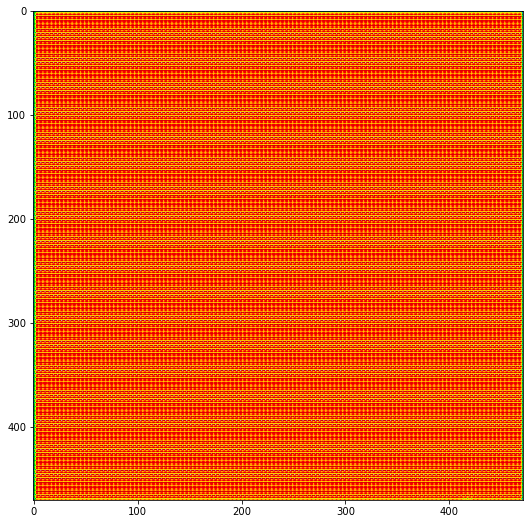

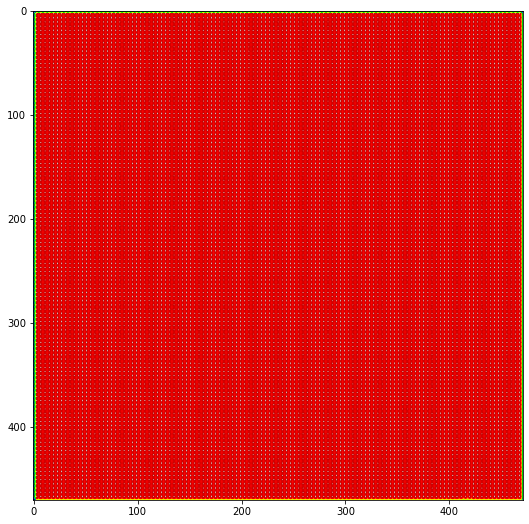

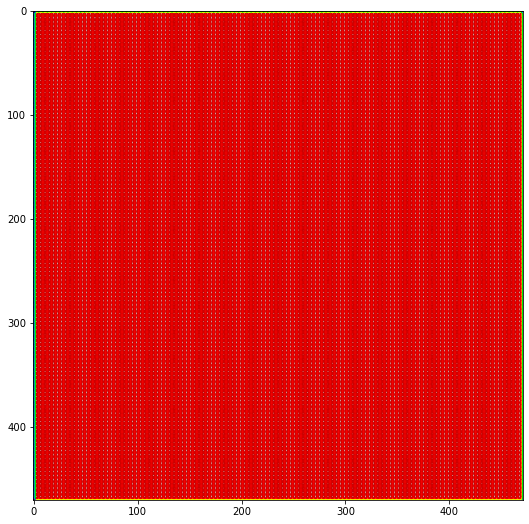

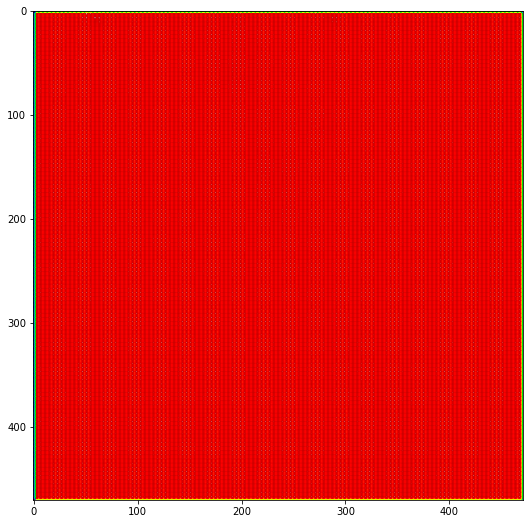

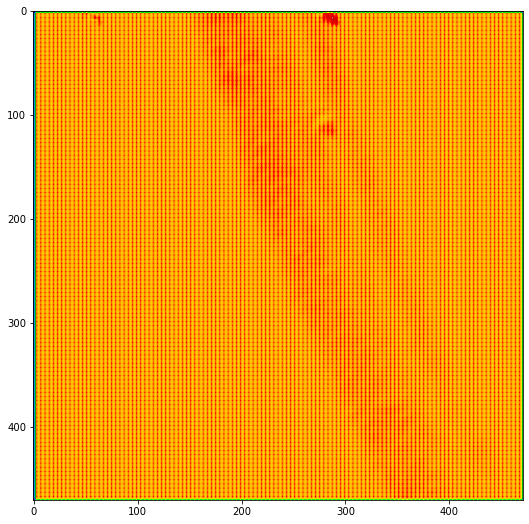

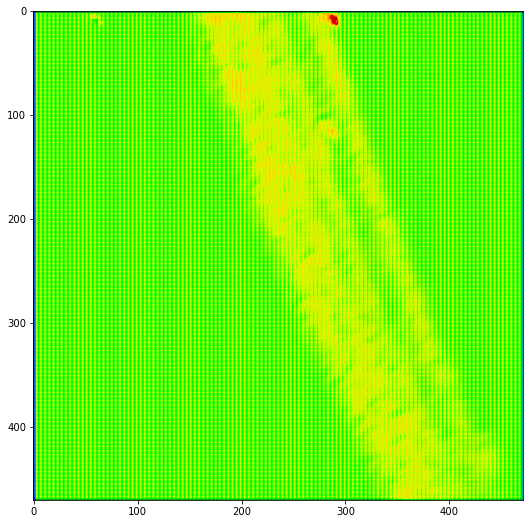

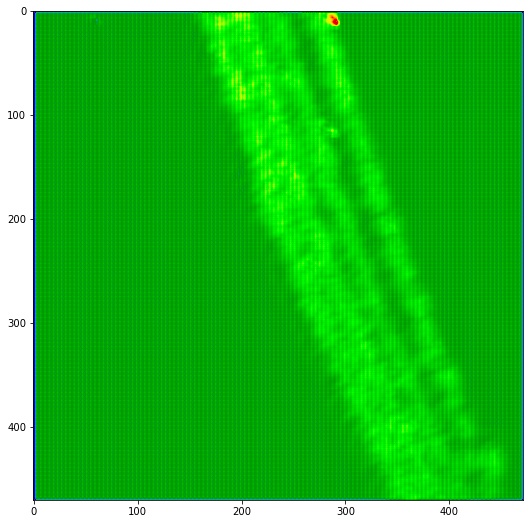

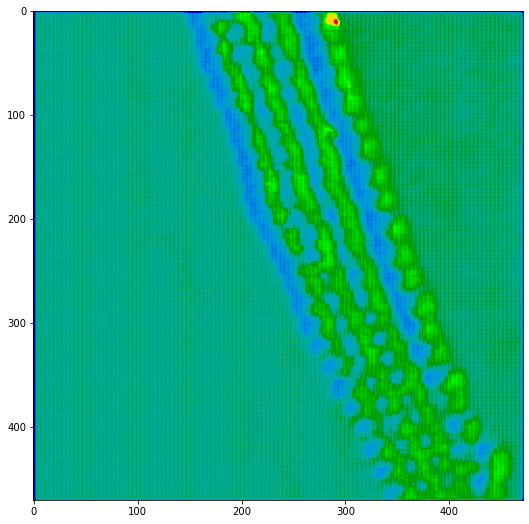

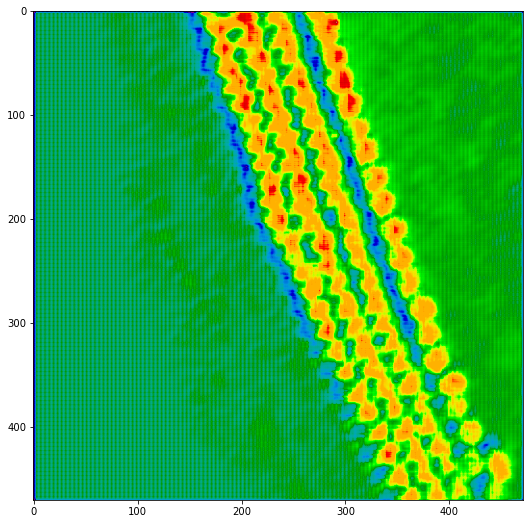

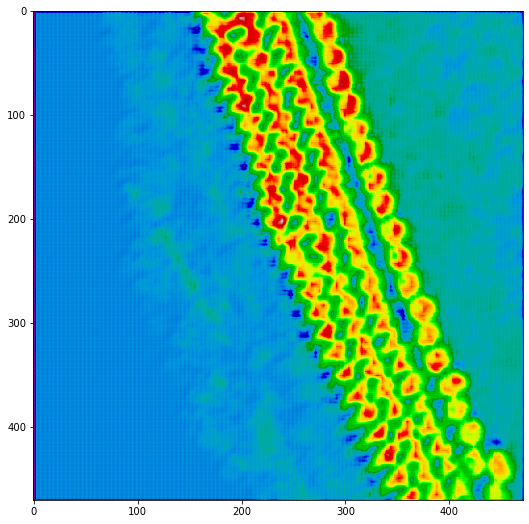

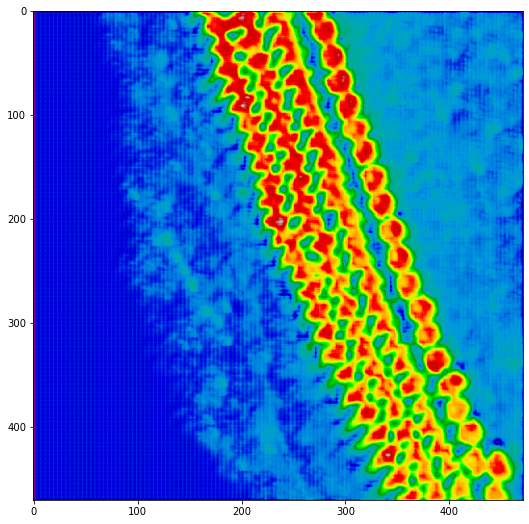

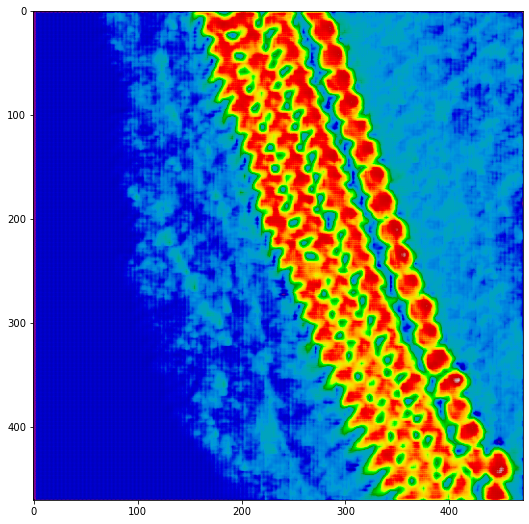

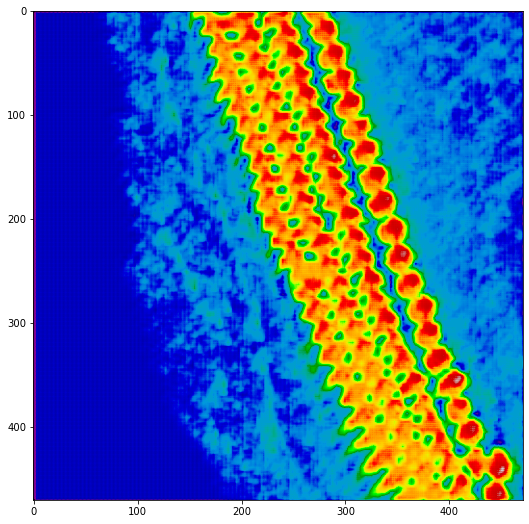

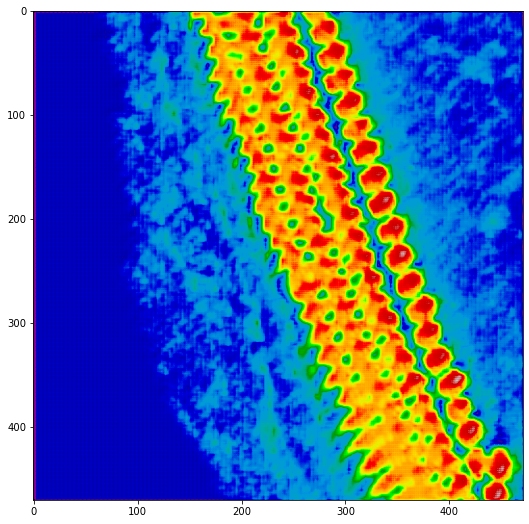

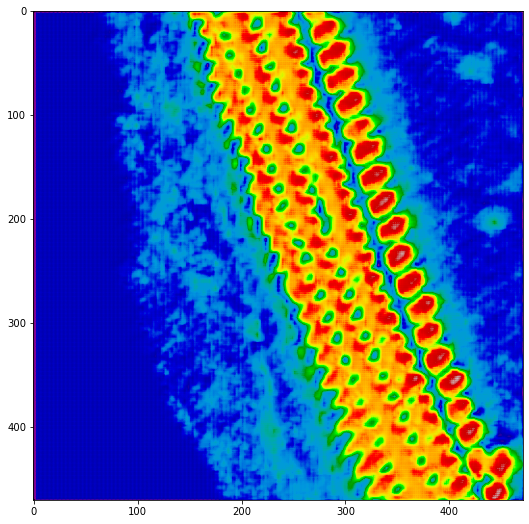

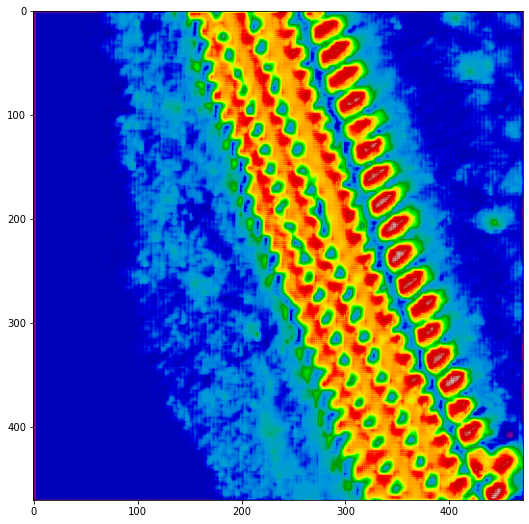

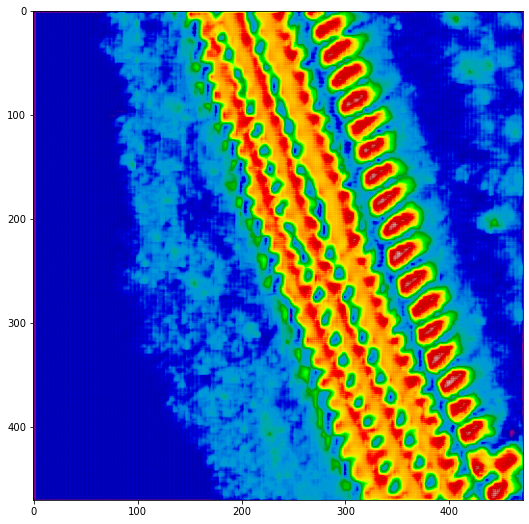

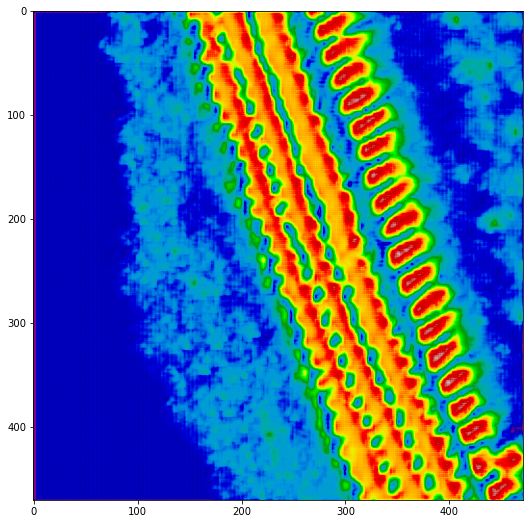

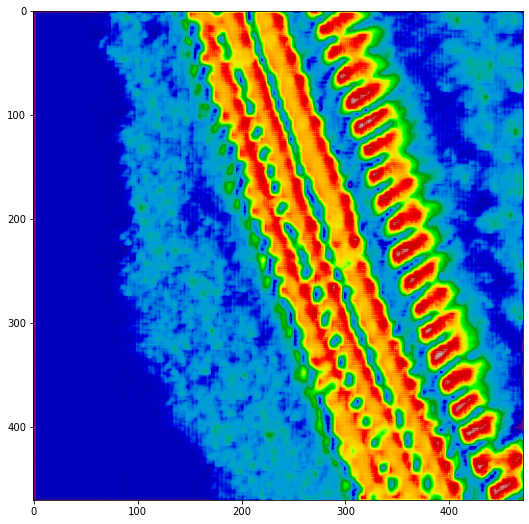

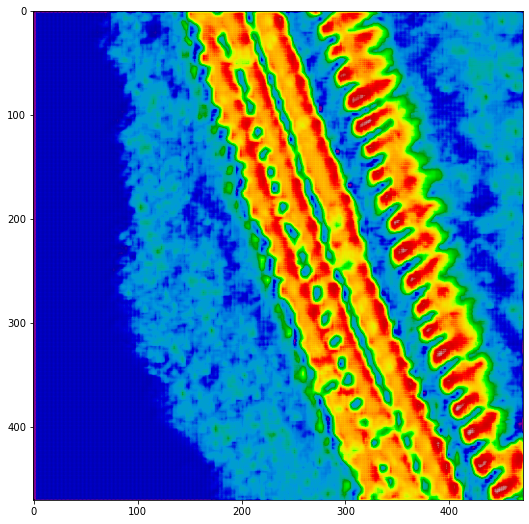

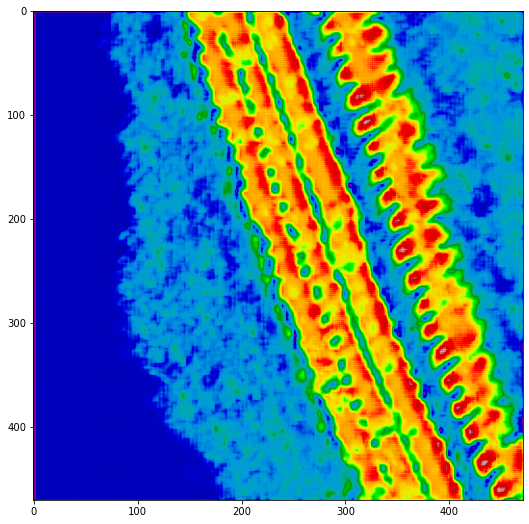

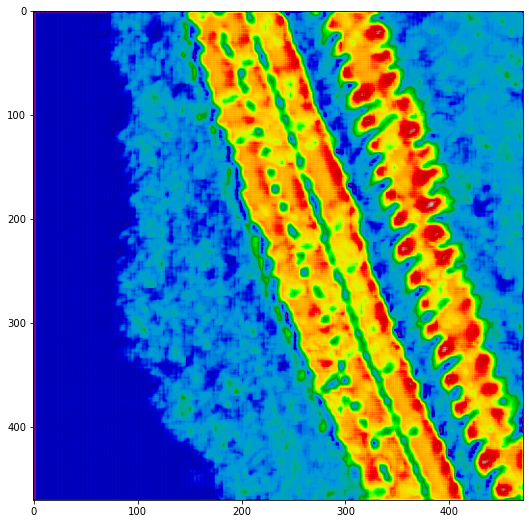

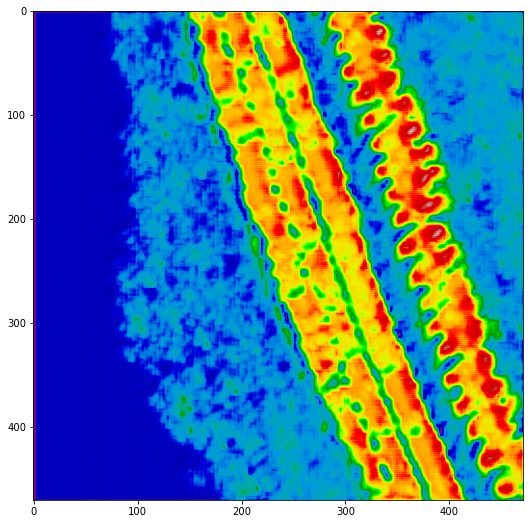

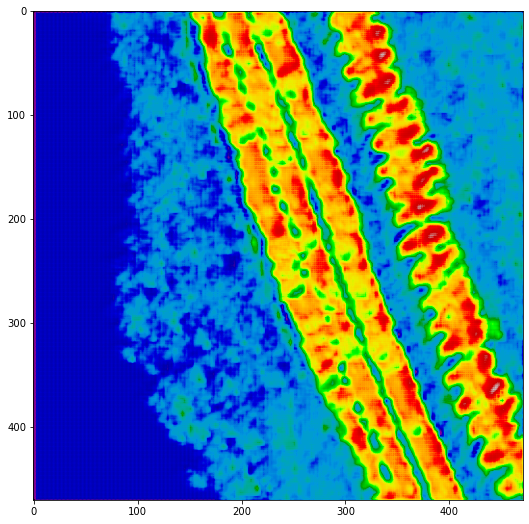

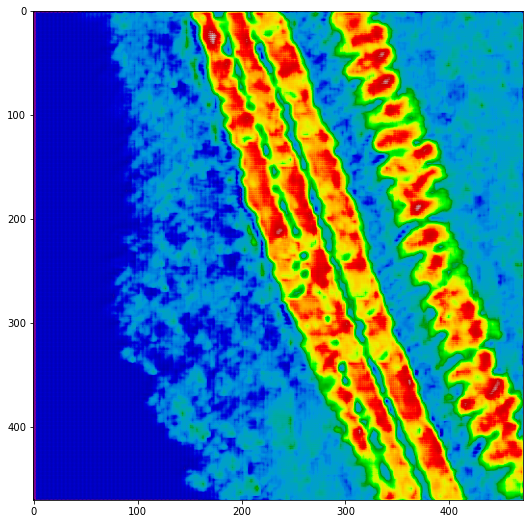

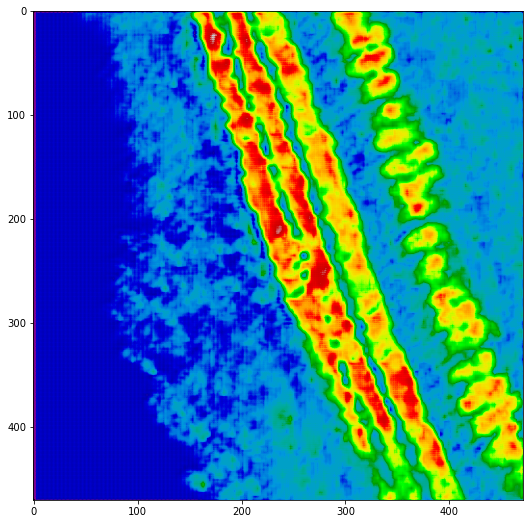

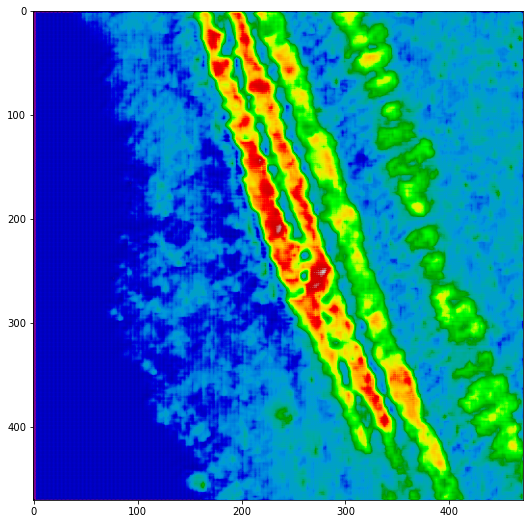

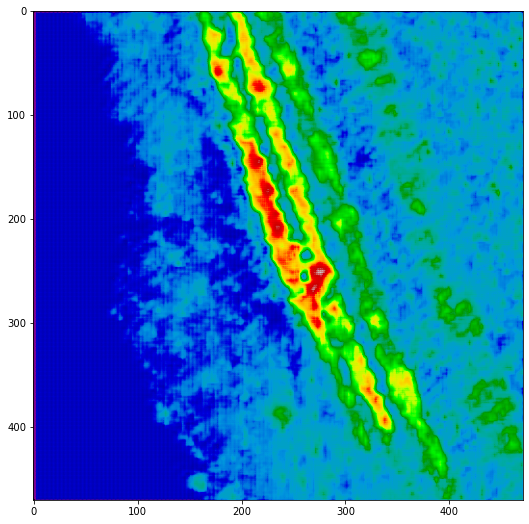

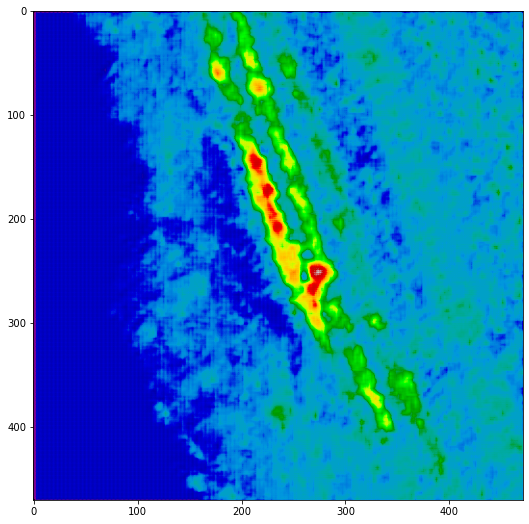

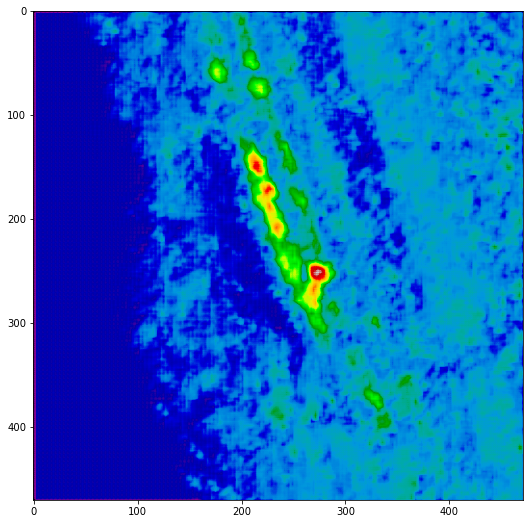

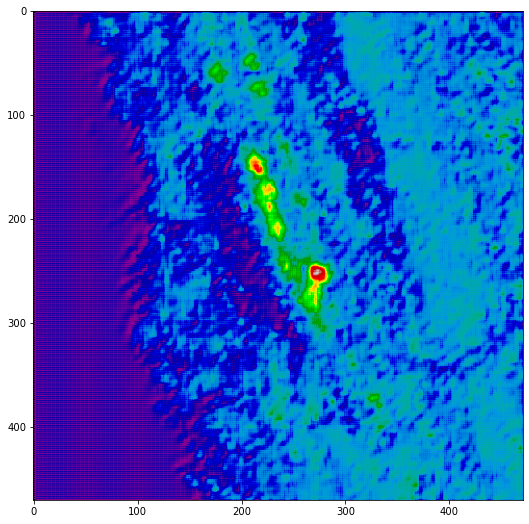

IndexError: index 31 is out of bounds for dimension 4 with size 31

<Figure size 648x648 with 0 Axes>

In [14]:
image, mask, pwl  = val_data[0]
#test.eval()
#test.cpu()
with torch.no_grad(): 
    out = test(image.float().cuda())
    print(f'IN SHAPE: {image.shape}')
    print(f'OUT SHAPE: {out.shape}')

#pred = F.sigmoid(out)
pred=out
for i in range(image.shape[-1]):
    plt.figure(figsize=(9,9))
    #plt.imshow(image[0,[0,2,1],:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    #plt.imshow(image[0,[1,2,3],:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    #plt.imshow(mask[0,0,:,:,i].float(), cmap = 'Greens')
    plt.imshow(pred[0,0,:,:,i].cpu().detach().numpy() , cmap=plt.cm.nipy_spectral,alpha=1)
    
    plt.show()


In [ ]:
mask.numpy().dtype

In [ ]:
for i in range(25):
    plt.imshow(mask.float().numpy()[0,0,:,:, i])
    plt.show()

In [ ]:
torch.cuda.empty_cache()